In [1]:
import pandas as pd
import numpy as np

Pre-analysis/data-cleaning

In [2]:
numParticipants = 30
nVideoPerCondition = 10
nTrialPerParticipant = 30
nCondition = 3

In [3]:
#retrieve label df
labels_path = 'labeled_output_0609.csv'
labels_df = pd.read_csv(labels_path)
#retrieve cleaned data df

#to-do: use relative path
anonymized_df_path = 'anonymized_data.csv'
anonymized_df = pd.read_csv(anonymized_df_path)

In [4]:
# Before merging with fine-tuned labels, test if two dfs have the same set of index
assert set(labels_df['Index']) == set(anonymized_df['Index'])

labels_df_cleaned = labels_df[['Index','readAction','category']]
labels_df_cleaned['Index'] =labels_df_cleaned['Index'].astype(int)
with_label_df = pd.merge(anonymized_df, labels_df_cleaned, on='Index')
print("Merged.")

Merged.


/var/folders/fd/xdm_85mx5pn2k8hz19bpy4_80000gn/T/ipykernel_43570/2295101854.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_df_cleaned['Index'] =labels_df_cleaned['Index'].astype(int)


In [5]:
#check if the merged df have correct number of rows and counts of videos
nRowCorrect = len(with_label_df) == numParticipants * nTrialPerParticipant
label_count_df = with_label_df.groupby(['subjectID','condition']).size().reset_index(name = "count")
nWrongVideoCount = len(label_count_df[label_count_df['count']!=nVideoPerCondition])
    
assert nRowCorrect and nWrongVideoCount==0
print("All counts are matched")

All counts are matched


In [6]:
#code identification from category
with_label_df['identified_int'] = (with_label_df['category']!='unidentified').astype(int)
#convert correctly identification to integer
with_label_df['readAction_int'] = with_label_df['readAction'].astype(int)
#manually correcting labeling error
with_label_df.loc[with_label_df['identified_int'] < with_label_df['readAction_int'], 'identified_int'] = 1
#get an additional column that calculate the inaccuracy
with_label_df['instrumental_diff'] = with_label_df['identified_int'] - with_label_df['readAction_int']

In [7]:
with_label_df.to_csv("with_label_df.csv")

Analysis starts here

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from math import atanh, tanh

In [9]:
conditions = ['do', 'far', 'absent']
position_map = {condition: i for i, condition in enumerate(conditions)}
colors = ['blue', 'green', 'orange']
actions = anonymized_df['action'].unique()

In [10]:
calculateSem = lambda x: x.sem()
calculate95CI = lambda x: (x.mean() - 1.96 * x.sem(), x.mean() + 1.96 * x.sem())

def runLinearRegression(X,y):
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_, model.intercept_


In [11]:
condition_rating_grouped_df = with_label_df.groupby(['subjectID','condition'])["rating"].mean().reset_index()
condition_rating_grouped_df = condition_rating_grouped_df.pivot(index='subjectID', columns='condition', values='rating')
condition_rating_grouped_df

condition,absent,do,far
subjectID,,,
0,4.3,3.9,4.5
1,3.9,6.7,5.8
2,3.5,1.9,4.7
3,5.1,1.1,4.6
4,2.8,4.6,5.3
5,4.7,5.5,5.9
6,3.2,6.1,4.5
7,3.8,6.7,6.1
8,4.6,1.4,5.5


In [12]:
# Check for normality for mean participant rating for each condition
for condition in conditions:
    w, p = stats.shapiro(condition_rating_grouped_df[condition])
    if p > 0.05:
        print(f'Normality Test for {condition} Condition: Passed (W = {w:.3f}, p = {p:.3f}). Data appears normally distributed.')
    else:
        print(f'Normality Test for {condition} Condition: Failed (W = {w:.3f}, p = {p:.3f}). Data does not appear normally distributed.')

# Check for homogeneity of variances across all conditions
w_levene, p_levene = stats.levene(condition_rating_grouped_df["do"], condition_rating_grouped_df["far"], condition_rating_grouped_df["absent"])
if p_levene > 0.05:
    print(f'Levene’s Test for Homogeneity of Variances: Passed (W = {w_levene:.3f}, p = {p_levene:.3f}). Assumption of homogeneity of variances holds.')
else:
    print(f'Levene’s Test for Homogeneity of Variances: Failed (W = {w_levene:.3f}, p = {p_levene:.3f}). Assumption of homogeneity of variances does not hold.')

Normality Test for do Condition: Passed (W = 0.935, p = 0.067). Data appears normally distributed.
Normality Test for far Condition: Passed (W = 0.943, p = 0.108). Data appears normally distributed.
Normality Test for absent Condition: Passed (W = 0.984, p = 0.925). Data appears normally distributed.
Levene’s Test for Homogeneity of Variances: Failed (W = 12.677, p = 0.000). Assumption of homogeneity of variances does not hold.


In [13]:
#get summary statistics for each context condition
condition_summary_stats = with_label_df.groupby(['condition']).agg(
    group_mean = ('rating','mean'),
    variance = ('rating','var'),
    SE = ('rating',calculateSem),
    CI95 = ('rating',calculate95CI)
).reset_index()

#sort according to condition order
condition_summary_stats['position'] = condition_summary_stats['condition'].map(position_map)
condition_summary_stats.sort_values('position', inplace=True)

condition_summary_stats

,condition,group_mean,variance,SE,CI95,position
1,do,4.083333,4.999721,0.129096,"(3.8303054737344646, 4.336361192932202)",0
2,far,5.246667,2.514203,0.091546,"(5.067236440161836, 5.426096893171498)",1
0,absent,3.900000,3.140468,0.102314,"(3.699463862421467, 4.100536137578533)",2


In [14]:
action_byContext_df = with_label_df.groupby(['action','condition'])['rating'].mean().reset_index()
action_byContext_df_pivoted = action_byContext_df.pivot(index='action', columns='condition', values='rating')
action_byContext_df_pivoted = action_byContext_df_pivoted[conditions]
action_byContext_df_pivoted

condition,do,far,absent
action,,,
blowCandle,3.9,5.4,3.5
brushTableBroom,3.3,5.1,3.0
chargePhone,4.0,5.9,2.5
closeJar,3.3,5.5,5.6
crushBottle,5.2,4.0,3.7
dispenseSoap,2.9,5.6,4.7
drawLine,4.9,4.9,4.6
drinkCup,4.9,5.8,5.2
drinkMug,3.4,4.2,3.6


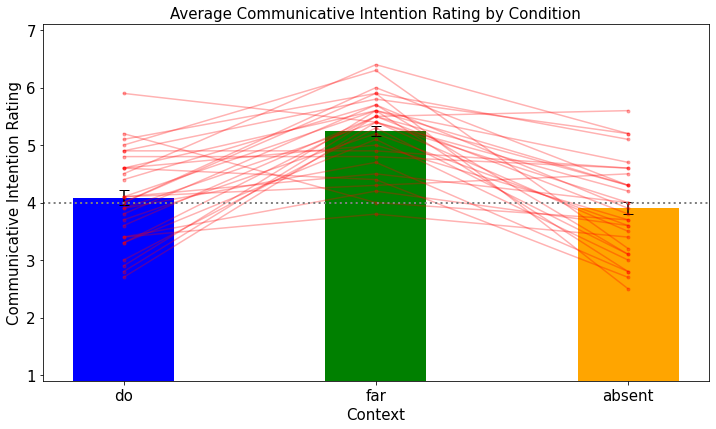

In [15]:
#plot main effect

positions = np.arange(nCondition)  # the label locations
width = 0.4
fig, ax = plt.subplots(figsize=(10, 6))
labels = conditions

bars = ax.bar(positions, condition_summary_stats['group_mean'], width, label=labels, yerr=condition_summary_stats['SE'], capsize=5, color=colors)

scatter_width = width / 2

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']*3

#plot linked scatters for each actions in different conditions
for idx, (action, ratings) in enumerate(action_byContext_df_pivoted.iterrows()):
    scatter_positions = positions  # Centered on each bar
    ax.plot(scatter_positions, ratings, color='red', marker='.', label=action, alpha = 0.3)

ax.set_xlabel('Context', fontsize = '15')
ax.set_ylabel('Communicative Intention Rating', fontsize = '15')
ax.set_title('Average Communicative Intention Rating by Condition', fontsize = '15')
ax.set_xticks(positions)
ax.set_xticklabels(condition_summary_stats['condition'])
ax.set_ylim([0.9, 7.1])
plt.tight_layout()
plt.axhline(y=4,linewidth=2, color='grey',linestyle=':')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()


In [16]:
readAction_summary_stats = with_label_df.groupby(['condition']).agg(
    mean_frequency=('readAction_int', 'mean'),
    sem=('readAction_int', calculateSem),  # Standard error of the mean
    CI95 = ('readAction_int', calculate95CI)
).reset_index()

readAction_summary_stats['position'] = readAction_summary_stats['condition'].map(position_map)
readAction_summary_stats.sort_values('position', inplace=True)
print(readAction_summary_stats)

  condition  mean_frequency       sem  \
1        do        0.970000  0.009865   
2       far        0.870000  0.019449   
0    absent        0.426667  0.028603   

                                       CI95  position  
1  (0.9506639851165782, 0.9893360148834217)         0  
2  (0.8318800976323163, 0.9081199023676837)         1  
0  (0.3706046868446145, 0.4827286464887189)         2  


In [17]:
identified_summary_stats = with_label_df.groupby(['condition']).agg(
    mean_frequency = ('identified_int', 'mean'),
    sem = ('identified_int', calculateSem),
    CI95 = ('identified_int',calculate95CI)
).reset_index()

identified_summary_stats['position'] = identified_summary_stats['condition'].map(position_map)
identified_summary_stats.sort_values('position', inplace=True)

identified_summary_stats

,condition,mean_frequency,sem,CI95,position
1,do,1.000000,0.000000,"(1.0, 1.0)",0
2,far,0.993333,0.004706,"(0.9841092683828718, 1.0025573982837948)",1
0,absent,0.946667,0.012995,"(0.9211972860365034, 0.9721360472968299)",2


In [18]:
subject_condition_instrumental_df = with_label_df.groupby(['condition','subjectID'])[['identified_int','readAction_int']].mean()

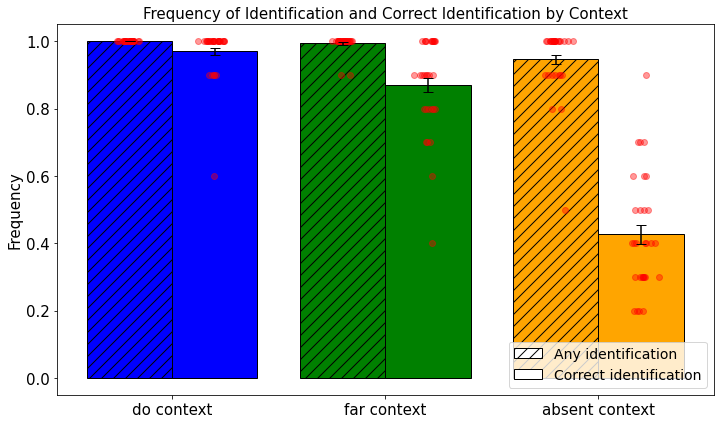

In [19]:
#plot correct identification of action by context
from matplotlib.patches import Patch

index = np.arange(nCondition)  # the label locations
width = 0.4
fig, ax = plt.subplots(figsize=(10, 6))
labels = readAction_summary_stats['condition']

hatches = ['//', '']

positions1 = index - width/2
positions2 = index + width/2
bars1 = ax.bar(positions1, identified_summary_stats['mean_frequency'], width, yerr=identified_summary_stats['sem'], capsize=5, color=colors, hatch = hatches[0], edgecolor='black')
bars2 = ax.bar(positions2, readAction_summary_stats['mean_frequency'], width, yerr=readAction_summary_stats['sem'], capsize=5, color=colors, hatch = hatches[1], edgecolor='black')


scatter_width = width / 2
for i, cond in enumerate(conditions):
    scatter_positions1 = np.random.normal(positions1[i], scatter_width / 8, numParticipants)
    scatter_positions2 = np.random.normal(positions2[i], scatter_width / 8, numParticipants)
    ax.scatter(scatter_positions1, subject_condition_instrumental_df.loc[cond,'identified_int'], color='red', alpha=0.4)
    ax.scatter(scatter_positions2, subject_condition_instrumental_df.loc[cond,'readAction_int'], color='red', alpha=0.4)
    

#ax.set_xlabel('Context', fontsize = '15')
ax.set_ylabel('Frequency', fontsize = '15')
ax.set_title('Frequency of Identification and Correct Identification by Context', fontsize = '15')
ax.set_xticks(positions)

x_label = [c + " context" for c in conditions ]
ax.set_xticklabels(x_label, fontsize = '15')

legend_handles = [
    Patch(facecolor='white', edgecolor='black', hatch=hatches[0], label='Any identification'),
    Patch(facecolor='white', edgecolor='black', hatch=hatches[1], label='Correct identification')
]

ax.legend(handles=legend_handles, loc='lower right',fontsize = '14')
ax.set_ylim([-0.05, 1.05])
plt.tight_layout()
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()


In [20]:
# interaction
from statsmodels.formula.api import ols

model = ols('instrumental_diff ~ C(condition)', data=with_label_df).fit()
anova_results = sm.stats.anova_lm(model, typ=1)
print(anova_results)

                 df      sum_sq    mean_sq           F        PR(>F)
C(condition)    2.0   40.615556  20.307778  156.971994  3.517806e-59
Residual      897.0  116.046667   0.129372         NaN           NaN


/var/folders/fd/xdm_85mx5pn2k8hz19bpy4_80000gn/T/ipykernel_43570/3867624424.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = pearsonr(x,y)


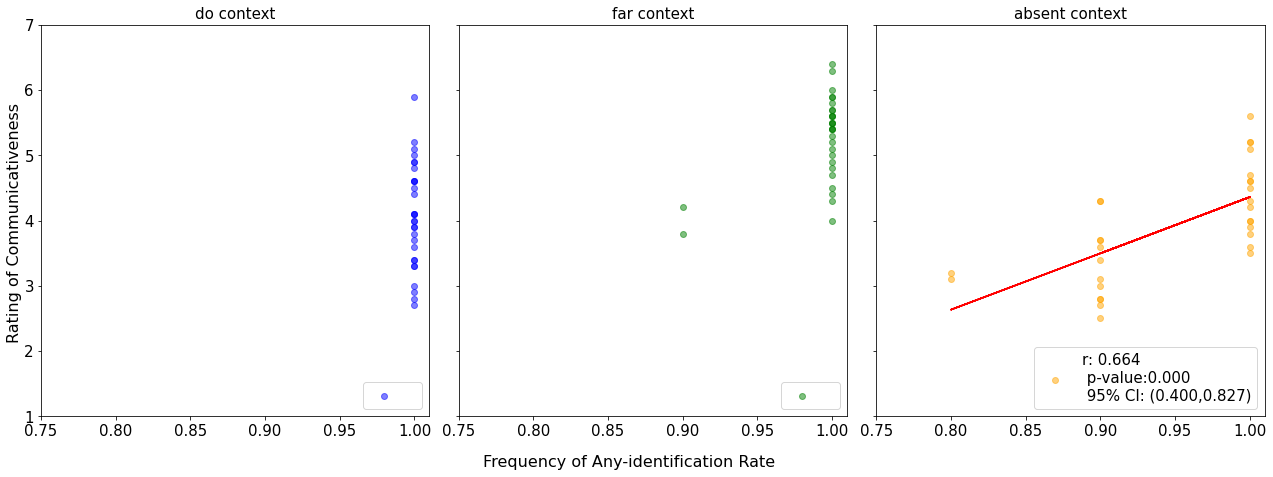

In [21]:
#correlation identification frequency and rating
fig, axes = plt.subplots(1, 3, figsize=(18, 7), sharey=True)

for i, c in enumerate(conditions):
    id_byAction_df = with_label_df[with_label_df['condition'] == c].groupby(['action']).agg(
    mean_rating=('rating', 'mean'),  # Calculate the mean of 'b'
    count_identified=('identified_int', 'mean')  # Count the number of entries in 'c'
    ).reset_index()

    x = id_byAction_df['count_identified']
    X = id_byAction_df[['count_identified']]
    y = id_byAction_df['mean_rating']
    
    res = pearsonr(x,y)
    r,p = res
    a, b = runLinearRegression(X,y)
    r_lower, r_upper = res.confidence_interval(confidence_level=0.95)

    y_hat = x * a + b

    label = " "
    if c=='absent':
        axes[i].plot(x, y_hat, color='red')  # Regression line
        label = f'r: {r:.3f} \n p-value:{p:.3f} \n 95% CI: ({r_lower:.3f},{r_upper:.3f})'
    axes[i].scatter(x, y, color=colors[i], alpha=0.5, label=label)
    axes[i].set_title(f'{c} context',fontsize = '15')
    axes[i].legend(loc='lower right', fontsize = '15', frameon = True)
    axes[i].set_ylim([1, 7])
    axes[i].set_xlim([0.75, 1.01])
    axes[i].tick_params(axis='both', which='major', labelsize=15)

    fig.supxlabel('Frequency of Any-identification Rate',fontsize = '16')
    fig.supylabel('Rating of Communicativeness',fontsize = '16')

    plt.tight_layout(rect=[0.005, 0, 1, 0.95])
    

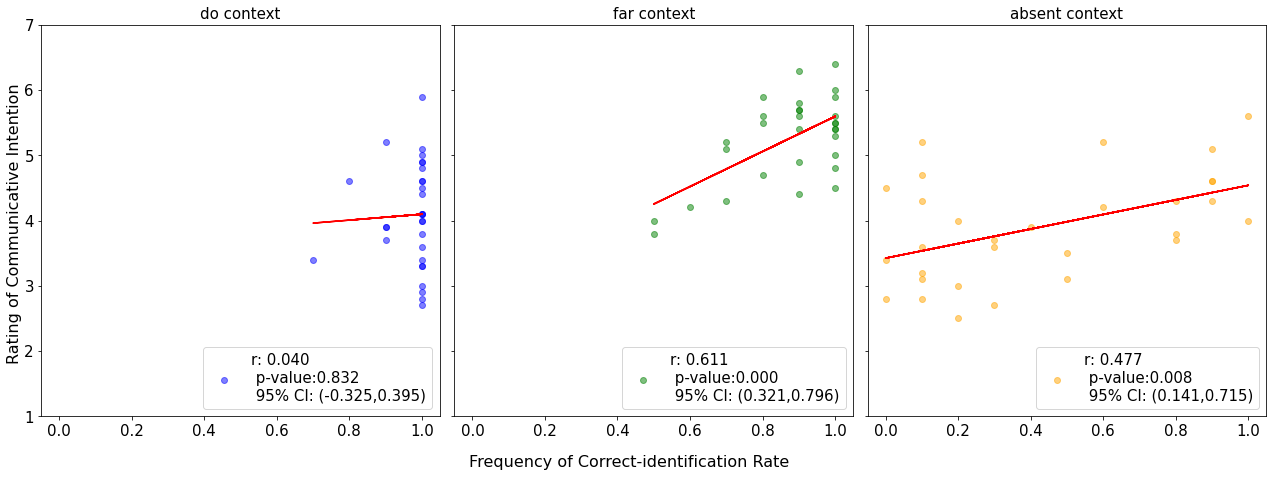

In [22]:
#plot correlation of correct identification frequency and mean rating

fig, axes = plt.subplots(1, 3, figsize=(18, 7), sharey=True)

for i,c in enumerate(conditions):
  df = with_label_df[with_label_df['condition'] == c].groupby(['action']).agg(
    mean_rating=('rating', 'mean'),  
    count_correct=('readAction_int', 'mean')  
    ).reset_index()
  x = df['count_correct']
  X = df[['count_correct']]
  y = df['mean_rating']

  res = pearsonr(x, y)
  corr_coef, p_value = res
  r_ci_lower, r_ci_upper = res.confidence_interval(0.95)
  coef, intercept = runLinearRegression(X,y)

  y_hat = x*coef + intercept

  label = f'r: {corr_coef:.3f} \n p-value:{p_value:.3f} \n 95% CI: ({r_ci_lower:.3f},{r_ci_upper:.3f})'
  axes[i].scatter(x, y, color=colors[i], alpha=0.5, label=label)
  axes[i].plot(x, y_hat, color='red')  # Regression line
  axes[i].set_title(f'{c} context', fontsize = '15')
  axes[i].legend(loc='lower right', fontsize = '15', frameon = True)
  axes[i].set_ylim([1, 7])
  axes[i].set_xlim([-0.05, 1.05])
  axes[i].tick_params(axis='both', which='major', labelsize=15)

fig.supxlabel('Frequency of Correct-identification Rate',fontsize = '16')
fig.supylabel('Rating of Communicative Intention',fontsize = '16')

# Adjust layout for clear display
plt.tight_layout(rect=[0.005, 0, 1, 0.95])

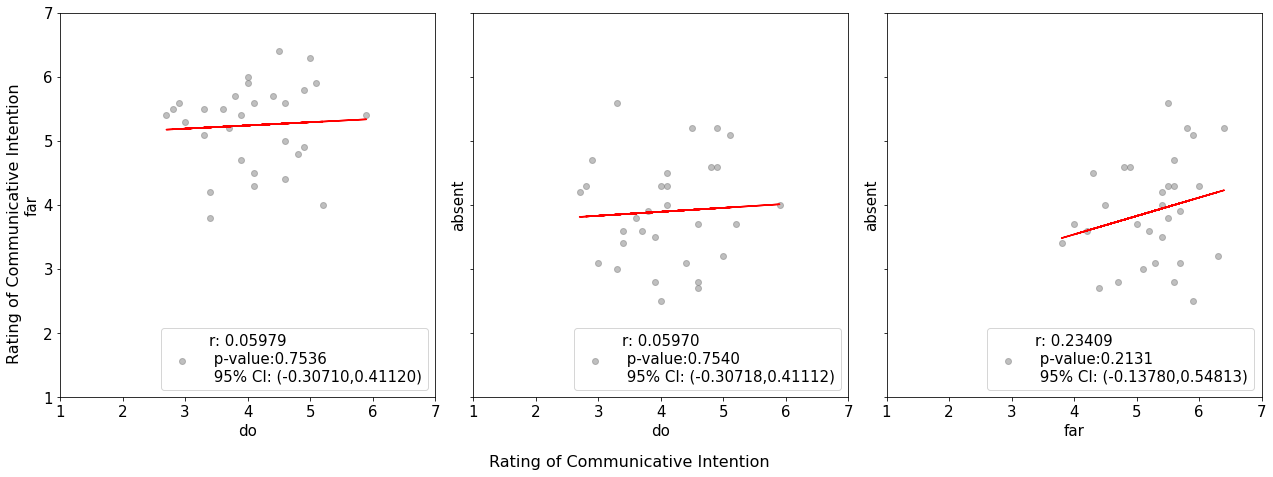

In [23]:
#plot context pair correlation rating
context_combo = list(combinations(conditions,2))

fig, axes = plt.subplots(1, 3, figsize=(18, 7), sharey=True)

for i, (c1, c2) in enumerate(context_combo):
  group1 = with_label_df[with_label_df['condition'] == c1].groupby(['action']).agg(
    mean_rating=('rating', 'mean')).reset_index()
  group2 = with_label_df[with_label_df['condition'] == c2].groupby(['action']).agg(
    mean_rating=('rating', 'mean')).reset_index()
  x = group1['mean_rating']
  X = group1[['mean_rating']]
  y = group2['mean_rating']

  res = pearsonr(x, y)
  corr_coef, p_value = res
  r_ci_lower, r_ci_upper = res.confidence_interval(0.95)
  coef, intercept = runLinearRegression(X,y)

  y_hat = x*coef + intercept

  label = f'r: {corr_coef:.5f} \n p-value:{p_value:.4f} \n 95% CI: ({r_ci_lower:.5f},{r_ci_upper:.5f})'
  axes[i].scatter(x, y, color='grey', alpha=0.5, label=label)
  axes[i].plot(x, y_hat, color='red')  # Regression line
  axes[i].set_xlabel(f'{c1}',fontsize = '15')
  axes[i].set_ylabel(f'{c2}',fontsize = '15')
  axes[i].legend(loc='lower right', fontsize = '15', frameon = True)
  axes[i].set_ylim([1, 7])
  axes[i].set_xlim([1, 7])
  axes[i].tick_params(axis='both', which='major', labelsize=15)

fig.supxlabel('Rating of Communicative Intention',fontsize = '16')
fig.supylabel('Rating of Communicative Intention',fontsize = '16')
plt.tight_layout(rect=[0.005, 0, 1, 0.95])

In [24]:
with_label_df.groupby(['condition'])[['instrumental_diff']].mean()

,instrumental_diff
condition,
absent,0.520000
do,0.030000
far,0.123333


In [31]:
action_instrumental_df = with_label_df.groupby(['action','condition']).agg(
    mean_any_id = ('identified_int', 'mean'),
    mean_correct_id = ('readAction_int', 'mean')
).reset_index()

action_instrumental_df_melted = pd.melt(action_instrumental_df, id_vars=['action','condition'], 
                           value_vars = ['mean_any_id','mean_correct_id'],
                           var_name='instrumental_type', value_name='instrumental_value')

action_instrumental_df_melted

,action,condition,instrumental_type,instrumental_value
0,blowCandle,absent,mean_any_id,1.0
1,blowCandle,do,mean_any_id,1.0
2,blowCandle,far,mean_any_id,1.0
3,brushTableBroom,absent,mean_any_id,0.9
4,brushTableBroom,do,mean_any_id,1.0
...,...,...,...,...
175,twistCube,do,mean_correct_id,1.0
176,twistCube,far,mean_correct_id,1.0
177,zipPlasticBag,absent,mean_correct_id,0.9
178,zipPlasticBag,do,mean_correct_id,1.0


In [30]:
import pingouin as pg
#anova for the interaction between identification type and context 
id_context_anova_results = pg.anova(data = action_instrumental_df_melted, dv = 'instrumental_value', between = ['condition','instrumental_type'], detailed = True)
print(id_context_anova_results)

                          Source        SS   DF        MS          F  \
0                      condition  3.037444    2  1.518722  59.012431   
1              instrumental_type  2.266889    1  2.266889  88.083668   
2  condition * instrumental_type  2.030778    2  1.015389  39.454593   
3                       Residual  4.478000  174  0.025736        NaN   

          p-unc       np2  
0  2.730609e-20  0.404160  
1  3.440136e-17  0.336090  
2  7.410783e-15  0.312006  
3           NaN       NaN  
